In [ ]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


In [ ]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


In [ ]:
import ncut_loss
import build_Unet
import build_Wnet
import getData

In [ ]:
from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

# DATASETS

In [5]:
path ='/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea'
parts_ds= []
dam_ds =[]
for d in os.listdir(path):
    if 'parts' in d:
        parts_ds.append(d)
    else:
        dam_ds.append(d)
        
path_damaged = [path+'/'+dam_ds[0]]

path_non_damaged = [path+'/'+parts_ds[1]]

#path_non_damaged = '/home/ubuntu/shared/data/meta/annotations/gold_standard/2021-06/parts_2021-06_val.json'
to_keep = ["bumper_back","bumper_front","door_back_left","door_back_right","door_front_left",    
"door_front_right","fender_back_left","fender_back_right","fender_front_left","fender_front_right"] 

#to_keep='all'

In [6]:
path_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/gs_40004_damages.json']

In [7]:
path_non_damaged

['/home/ubuntu/shared/perso/nicolas/Projets/Classifieur_idea/generate_positive_and_negative_from_idea/73822_parts.json']

In [8]:
dam_gen = get_damaged_generator(path_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  25%|##5       | 1771/6968 [00:01<00:02, 1767.08it/s]

In [9]:
non_dam_gen = get_non_damaged_generator(path_non_damaged, batch_size=1, dim=(128,128), to_keep=to_keep,area_threshold=5000)

Importing from COCO JSON:  15%|#5        | 1120/7384 [00:01<00:05, 1118.88it/s]

(1, 128, 128, 3)


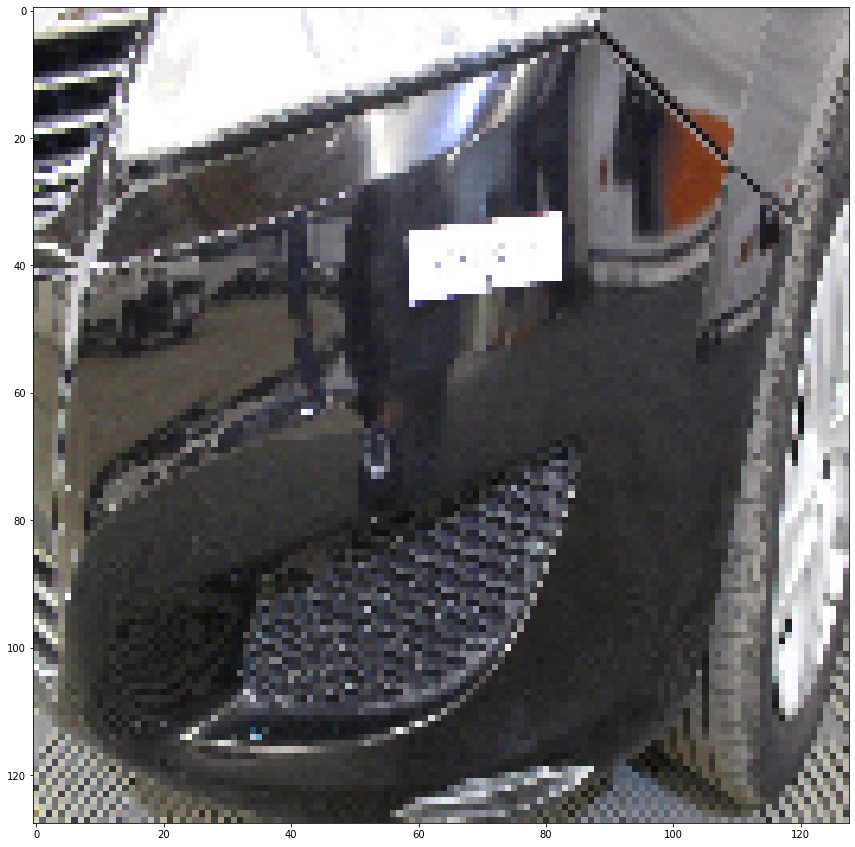

In [10]:
dam = dam_gen.__getitem__(np.random.randint(1,1000))
print(dam.shape)
plt.figure(figsize=(15,15))
plt.imshow(dam[0])


In [11]:
len(non_dam_gen.map_id)

9894

(1, 128, 128, 3)


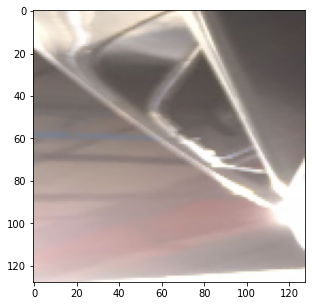

In [12]:
ndam = non_dam_gen.__getitem__(np.random.randint(1,1000))
print(ndam.shape)
plt.figure(figsize=(5,5))
plt.imshow(ndam[0])


In [13]:
len(dam_gen.map_id)

2425

# MODEL

In [14]:
neighbor_filter=ncut_loss.neighbor_filter((128,128))

In [15]:
encoder = build_Unet.build_Unet(K=10,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
decoder = build_Unet.build_Unet(K=10,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
wn = build_Wnet.Wnet(encoder,decoder,(128,128))

def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


In [16]:
wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/Wnet10/ckpt500")

In [20]:
def rescale(image):
    return( (((image+1)/2)*255 ).astype("uint8") )

In [21]:
def visualise_seg(image,encoder):
    image = tf.expand_dims(image, 0)
    
    seg = encoder(image)
    ag = tf.math.argmax(seg, axis=-1, output_type=tf.dtypes.int64)
    
    print(image.shape)
    print(wn(image).shape)
    
    
    print(type(image))
    loss = ncut_loss.compute_soft_ncuts(image,seg,neighbor_filter)
    
    
    loss_r = tf.keras.losses.MeanSquaredError()(image,wn(image))
    
    print(loss_r)
    res = wn(image).numpy()[0]
    res = rescale(res)
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(ag[0])
    plt.subplot(1,2,2)
    plt.imshow(res)
    print(loss)

(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.040644705, shape=(), dtype=float32)
tf.Tensor(8.052494, shape=(), dtype=float32)


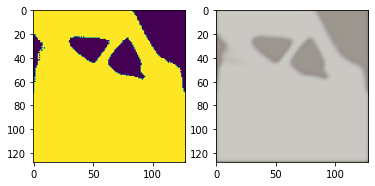

In [22]:
visualise_seg(ndam[0],wn.encoder)


(1, 128, 128, 3)
(1, 128, 128, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor(0.046858054, shape=(), dtype=float32)
tf.Tensor(8.034875, shape=(), dtype=float32)


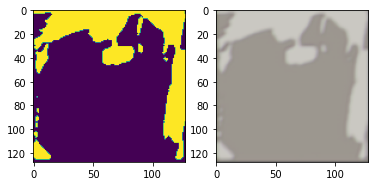

In [23]:
visualise_seg(dam[0],wn.encoder)

In [ ]:
dams_reco = []
ndams_reco = []

dams_seg = []
ndams_seg = []

for i in range(0,500):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg.append(seg_loss_dam.numpy())
    ndams_seg.append(seg_loss_ndam.numpy())
    
    dams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
    ndams_reco.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

In [ ]:
data = {'dam':dams_reco,'non_dam':ndams_reco}
df = pd.DataFrame(data=data)
sns.boxplot(data=df)

In [ ]:
x_plot = ndams_reco+dams_reco
y_plot = dams_seg+ndams_seg
label = [0]*500+[1]*500
plt.scatter(x_plot, y_plot, s=200, c=label,alpha=0.2)

In [ ]:
X_clf = np.array([ndams_reco+dams_reco,ndams_seg+dams_seg])
y_clf = [0]*500+[1]*500
clf = LogisticRegression()
clf.fit(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))



In [ ]:
dams_reco_test = []
ndams_reco_test = []

dams_seg_test = []
ndams_seg_test = []

for i in range(500,1001):
    ndam = tf.convert_to_tensor(non_dam_gen.__getitem__(i))
    
    dam = tf.convert_to_tensor(dam_gen.__getitem__(i))
    
    seg_dam = wn.encoder(dam)
    seg_ndam = wn.encoder(ndam)
    
    seg_loss_ndam = ncut_loss.compute_soft_ncuts(ndam,seg_ndam,neighbor_filter)
    seg_loss_dam = ncut_loss.compute_soft_ncuts(dam,seg_dam,neighbor_filter)
    
    dams_seg_test.append(seg_loss_dam.numpy())
    ndams_seg_test.append(seg_loss_ndam.numpy())
    
    dams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(dam)).numpy())
    ndams_reco_test.append(tf.keras.losses.MeanSquaredError()(ndam,wn(ndam)).numpy())
    

In [ ]:
X_test = np.array([ndams_reco_test+dams_reco_test,ndams_seg_test+dams_seg_test])
y_test = [0]*500+[1]*500
clf.score(np.array(X_clf).reshape(-1,2),np.array(y_clf).reshape(-1, 1))
